# Real Estate Data Analysis - Fixed Version

This notebook analyzes apartment rental data with proper data preprocessing, visualization, and machine learning pipeline.


## 1. Data Loading and Initial Setup


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib backend to avoid font cache issues
import matplotlib
matplotlib.use('Agg')

%matplotlib inline


Could not save font_manager cache [Errno 13] Permission denied: 'C:\\Users\\aewee\\.matplotlib\\fontlist-v390.json.matplotlib-lock'


In [2]:
# Load the dataset
print("Loading dataset...")
apartment_for_rent_classified = fetch_ucirepo(id=555)

# Extract features and target
X = apartment_for_rent_classified.data.features
y = apartment_for_rent_classified.data.targets

# Combine features and target into a single DataFrame
df = pd.concat([X, y], axis=1)

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Check data types and fix mixed types
print("\nData types before cleaning:")
print(df.dtypes)

# Convert numerical columns that might be stored as strings
numerical_columns = ['price', 'latitude', 'longitude', 'time']
for col in numerical_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert specific columns that should be numeric
if 'bathrooms' in df.columns:
    df['bathrooms'] = pd.to_numeric(df['bathrooms'], errors='coerce')
if 'bedrooms' in df.columns:
    df['bedrooms'] = pd.to_numeric(df['bedrooms'], errors='coerce')
if 'square_feet' in df.columns:
    df['square_feet'] = pd.to_numeric(df['square_feet'], errors='coerce')

print("\nData types after cleaning:")
print(df.dtypes)

df.head()


Loading dataset...
Dataset loaded successfully!
Shape: (99826, 21)
Columns: ['category', 'title', 'body', 'amenities', 'bathrooms', 'bedrooms', 'currency', 'fee', 'has_photo', 'pets_allowed', 'price', 'price_display', 'price_type', 'square_feet', 'address', 'cityname', 'state', 'latitude', 'longitude', 'source', 'time']

Data types before cleaning:
category          object
title             object
body              object
amenities         object
bathrooms         object
bedrooms          object
currency          object
fee               object
has_photo         object
pets_allowed      object
price            float64
price_display     object
price_type        object
square_feet       object
address           object
cityname          object
state             object
latitude         float64
longitude        float64
source            object
time             float64
dtype: object

Data types after cleaning:
category          object
title             object
body              object
ameniti

,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,pets_allowed,...,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,housing/rent/apartment,One BR 507 & 509 Esplanade,"This unit is located at 507 & 509 Esplanade, R...",NaN,1.0,1.0,USD,No,Thumbnail,Cats,...,2195,Monthly,542.0,507 509 Esplanade,Redondo Beach,CA,33.8520,-118.3759,RentLingo,1.577360e+09
1,housing/rent/apartment,Three BR 146 Lochview Drive,"This unit is located at 146 Lochview Drive, Ne...",NaN,1.5,3.0,USD,No,Thumbnail,"Cats,Dogs",...,1250,Monthly,1500.0,146 Lochview Dr,Newport News,VA,37.0867,-76.4941,RentLingo,1.577360e+09
2,housing/rent/apartment,Three BR 3101 Morningside Drive,This unit is located at 3101 Morningside Drive...,NaN,2.0,3.0,USD,No,Thumbnail,NaN,...,1395,Monthly,1650.0,3101 Morningside Dr,Raleigh,NC,35.8230,-78.6438,RentLingo,1.577360e+09
3,housing/rent/apartment,Two BR 209 Aegean Way,"This unit is located at 209 Aegean Way, Vacavi...",NaN,1.0,2.0,USD,No,Thumbnail,"Cats,Dogs",...,1600,Monthly,820.0,209 Aegean Way,Vacaville,CA,38.3622,-121.9712,RentLingo,1.577360e+09
4,housing/rent/apartment,One BR 4805 Marquette NE,"This unit is located at 4805 Marquette NE, Alb...",NaN,1.0,1.0,USD,No,Thumbnail,"Cats,Dogs",...,975,Monthly,624.0,4805 Marquette NE,Albuquerque,NM,35.1038,-106.6110,RentLingo,1.577360e+09


## 2. Exploratory Data Analysis


In [3]:
# Basic information about the dataset
print("Dataset Information:")
print("=" * 50)
df.info()

print("\nMissing Values:")
print("=" * 50)
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Percentage', ascending=False))


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99826 entries, 0 to 99825
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   category       99826 non-null  object 
 1   title          99826 non-null  object 
 2   body           99826 non-null  object 
 3   amenities      83749 non-null  object 
 4   bathrooms      99757 non-null  float64
 5   bedrooms       99696 non-null  float64
 6   currency       99822 non-null  object 
 7   fee            99823 non-null  object 
 8   has_photo      99823 non-null  object 
 9   pets_allowed   39192 non-null  object 
 10  price          99821 non-null  float64
 11  price_display  99820 non-null  object 
 12  price_type     99823 non-null  object 
 13  square_feet    99821 non-null  float64
 14  address        7946 non-null   object 
 15  cityname       99521 non-null  object 
 16  state          99521 non-null  object 
 17  latitude       99797 non-null

In [4]:
# Statistical summary of numerical columns
print("Statistical Summary of Numerical Columns:")
print("=" * 50)
numerical_cols = df.select_dtypes(include=[np.number]).columns
if len(numerical_cols) > 0:
    print(df[numerical_cols].describe())
else:
    print("No numerical columns found!")

print("\nStatistical Summary of Categorical Columns:")
print("=" * 50)
categorical_cols = df.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    print(df[categorical_cols].describe())
else:
    print("No categorical columns found!")

# Check for any remaining mixed-type issues
print("\nChecking for data type issues:")
for col in df.columns:
    if df[col].dtype == 'object':
        # Check if this column has mixed types
        try:
            pd.to_numeric(df[col], errors='raise')
            print(f"Column '{col}' contains only numeric data but is stored as object")
        except:
            print(f"Column '{col}' contains mixed or non-numeric data (this is expected for categorical columns)")


Statistical Summary of Numerical Columns:
          bathrooms      bedrooms         price   square_feet      latitude  \
count  99757.000000  99696.000000  99821.000000  99821.000000  9.979700e+04   
mean       1.445332      1.727983   1527.208493    956.402487  3.147604e+04   
std        0.546906      0.748941    903.635759    417.261273  7.022820e+06   
min        1.000000      0.000000    100.000000     37.624900  1.957380e+01   
25%        1.000000      1.000000   1014.000000    729.000000  3.374960e+01   
50%        1.000000      2.000000   1350.000000    900.000000  3.722970e+01   
75%        2.000000      2.000000   1795.000000   1115.000000  3.995390e+01   
max        9.000000      9.000000  52500.000000  50000.000000  1.568782e+09   

          longitude          time  
count  99795.000000  9.982000e+04  
mean     -91.562177  1.559690e+09  
std       15.819296  1.104487e+07  
min     -159.369800  1.544174e+09  
25%     -104.791900  1.550832e+09  
50%      -84.562300  1.568745e

In [5]:
# Additional data type conversion for columns that should be numeric
print("Converting additional columns to proper data types...")

# Convert columns that should be numeric but are stored as objects
numeric_object_columns = ['bathrooms', 'bedrooms', 'square_feet']
for col in numeric_object_columns:
    if col in df.columns:
        print(f"Converting {col} from {df[col].dtype} to numeric...")
        df[col] = pd.to_numeric(df[col], errors='coerce')
        print(f"  {col} is now {df[col].dtype}")

# Check final data types
print("\nFinal data types:")
print(df.dtypes)

# Check for any remaining NaN values after conversion
print("\nNaN values after conversion:")
nan_counts = df.isnull().sum()
print(nan_counts[nan_counts > 0])


Converting additional columns to proper data types...
Converting bathrooms from float64 to numeric...
  bathrooms is now float64
Converting bedrooms from float64 to numeric...
  bedrooms is now float64
Converting square_feet from float64 to numeric...
  square_feet is now float64

Final data types:
category          object
title             object
body              object
amenities         object
bathrooms        float64
bedrooms         float64
currency          object
fee               object
has_photo         object
pets_allowed      object
price            float64
price_display     object
price_type        object
square_feet      float64
address           object
cityname          object
state             object
latitude         float64
longitude        float64
source            object
time             float64
dtype: object

NaN values after conversion:
amenities        16077
bathrooms           69
bedrooms           130
currency             4
fee                  3
has_photo       

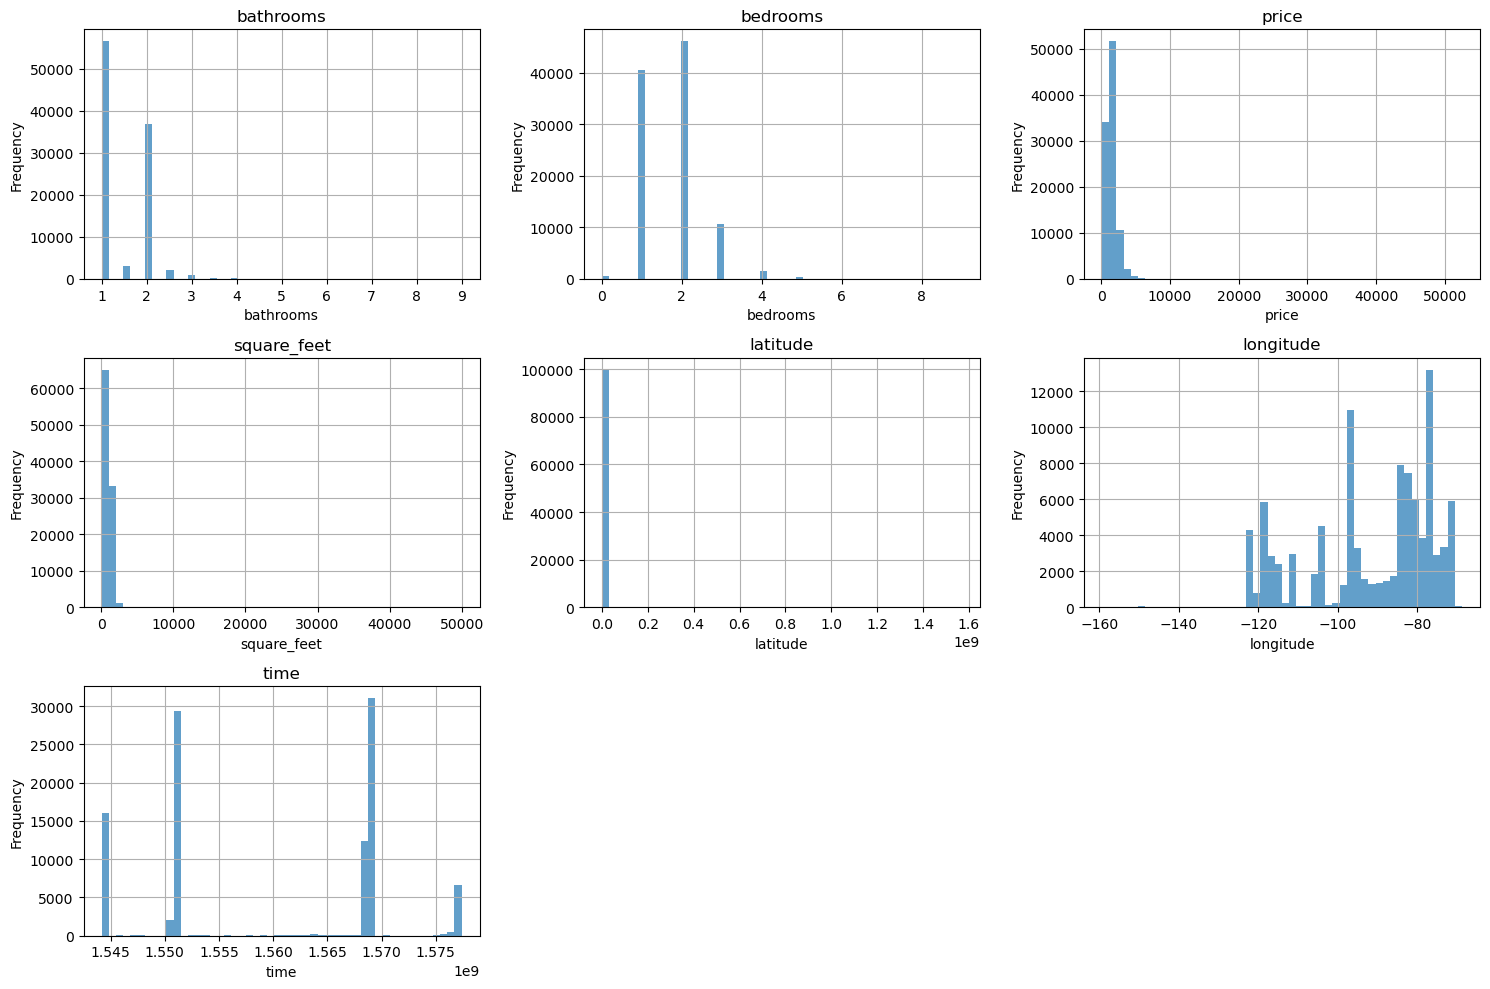

In [6]:
# Visualizations for numerical columns
plt.figure(figsize=(15, 10))
numerical_cols = df.select_dtypes(include=[np.number]).columns

if len(numerical_cols) > 0:
    # Calculate subplot layout
    n_cols = min(3, len(numerical_cols))
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
    
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        # Remove NaN values for plotting
        clean_data = df[col].dropna()
        if len(clean_data) > 0:
            clean_data.hist(bins=50, alpha=0.7)
            plt.title(f'{col}')
            plt.xlabel(col)
            plt.ylabel('Frequency')
        else:
            plt.text(0.5, 0.5, f'No data for {col}', ha='center', va='center')
            plt.title(f'{col} (No Data)')

    plt.tight_layout()
    plt.show()
else:
    print("No numerical columns found for visualization!")


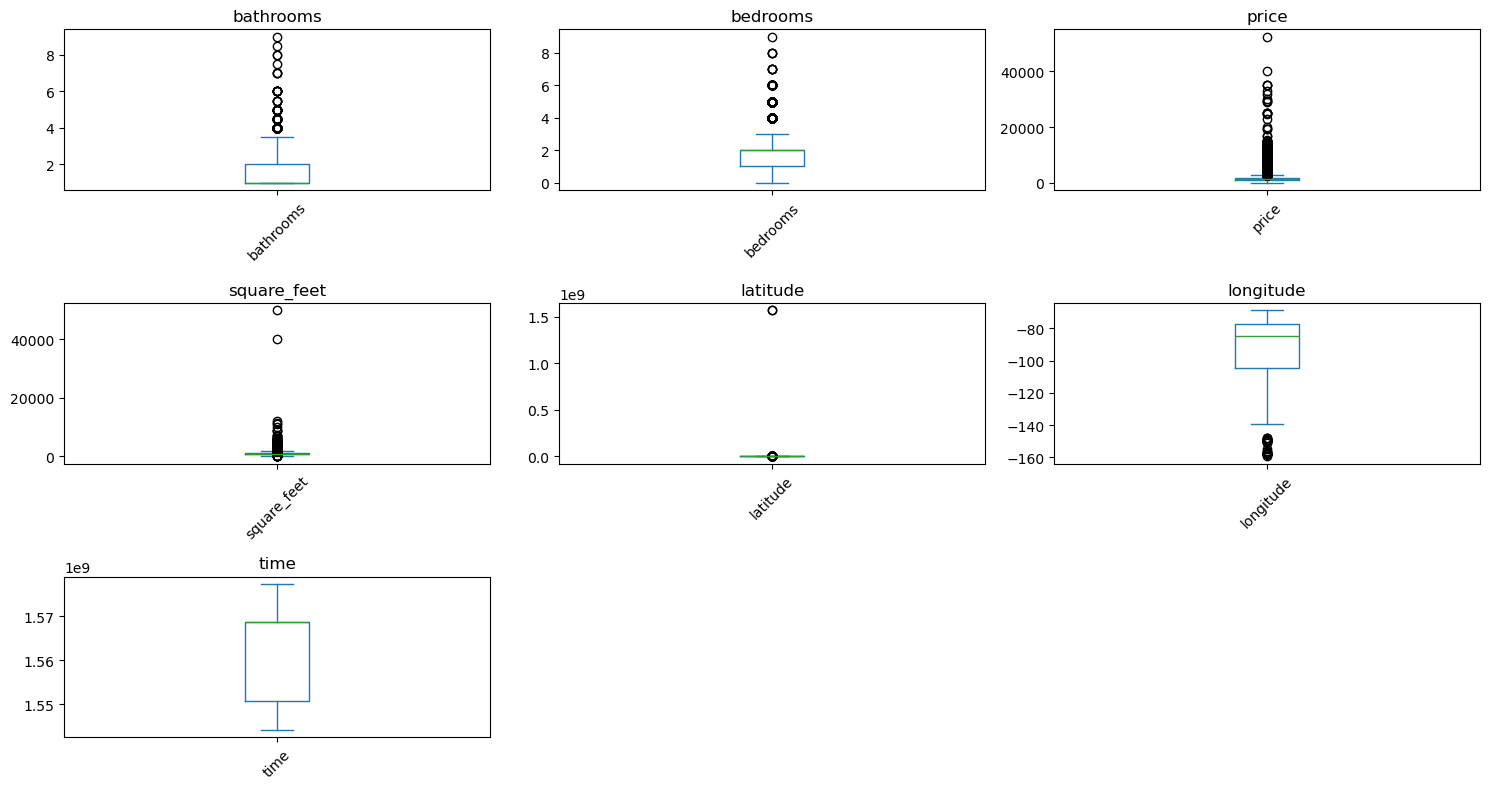

In [7]:
# Box plots for numerical columns to identify outliers
plt.figure(figsize=(15, 8))
numerical_cols = df.select_dtypes(include=[np.number]).columns

if len(numerical_cols) > 0:
    # Calculate subplot layout
    n_cols = min(3, len(numerical_cols))
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
    
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        # Remove NaN values for plotting
        clean_data = df[col].dropna()
        if len(clean_data) > 0:
            clean_data.plot(kind='box')
            plt.title(f'{col}')
            plt.xticks(rotation=45)
        else:
            plt.text(0.5, 0.5, f'No data for {col}', ha='center', va='center')
            plt.title(f'{col} (No Data)')

    plt.tight_layout()
    plt.show()
else:
    print("No numerical columns found for box plots!")


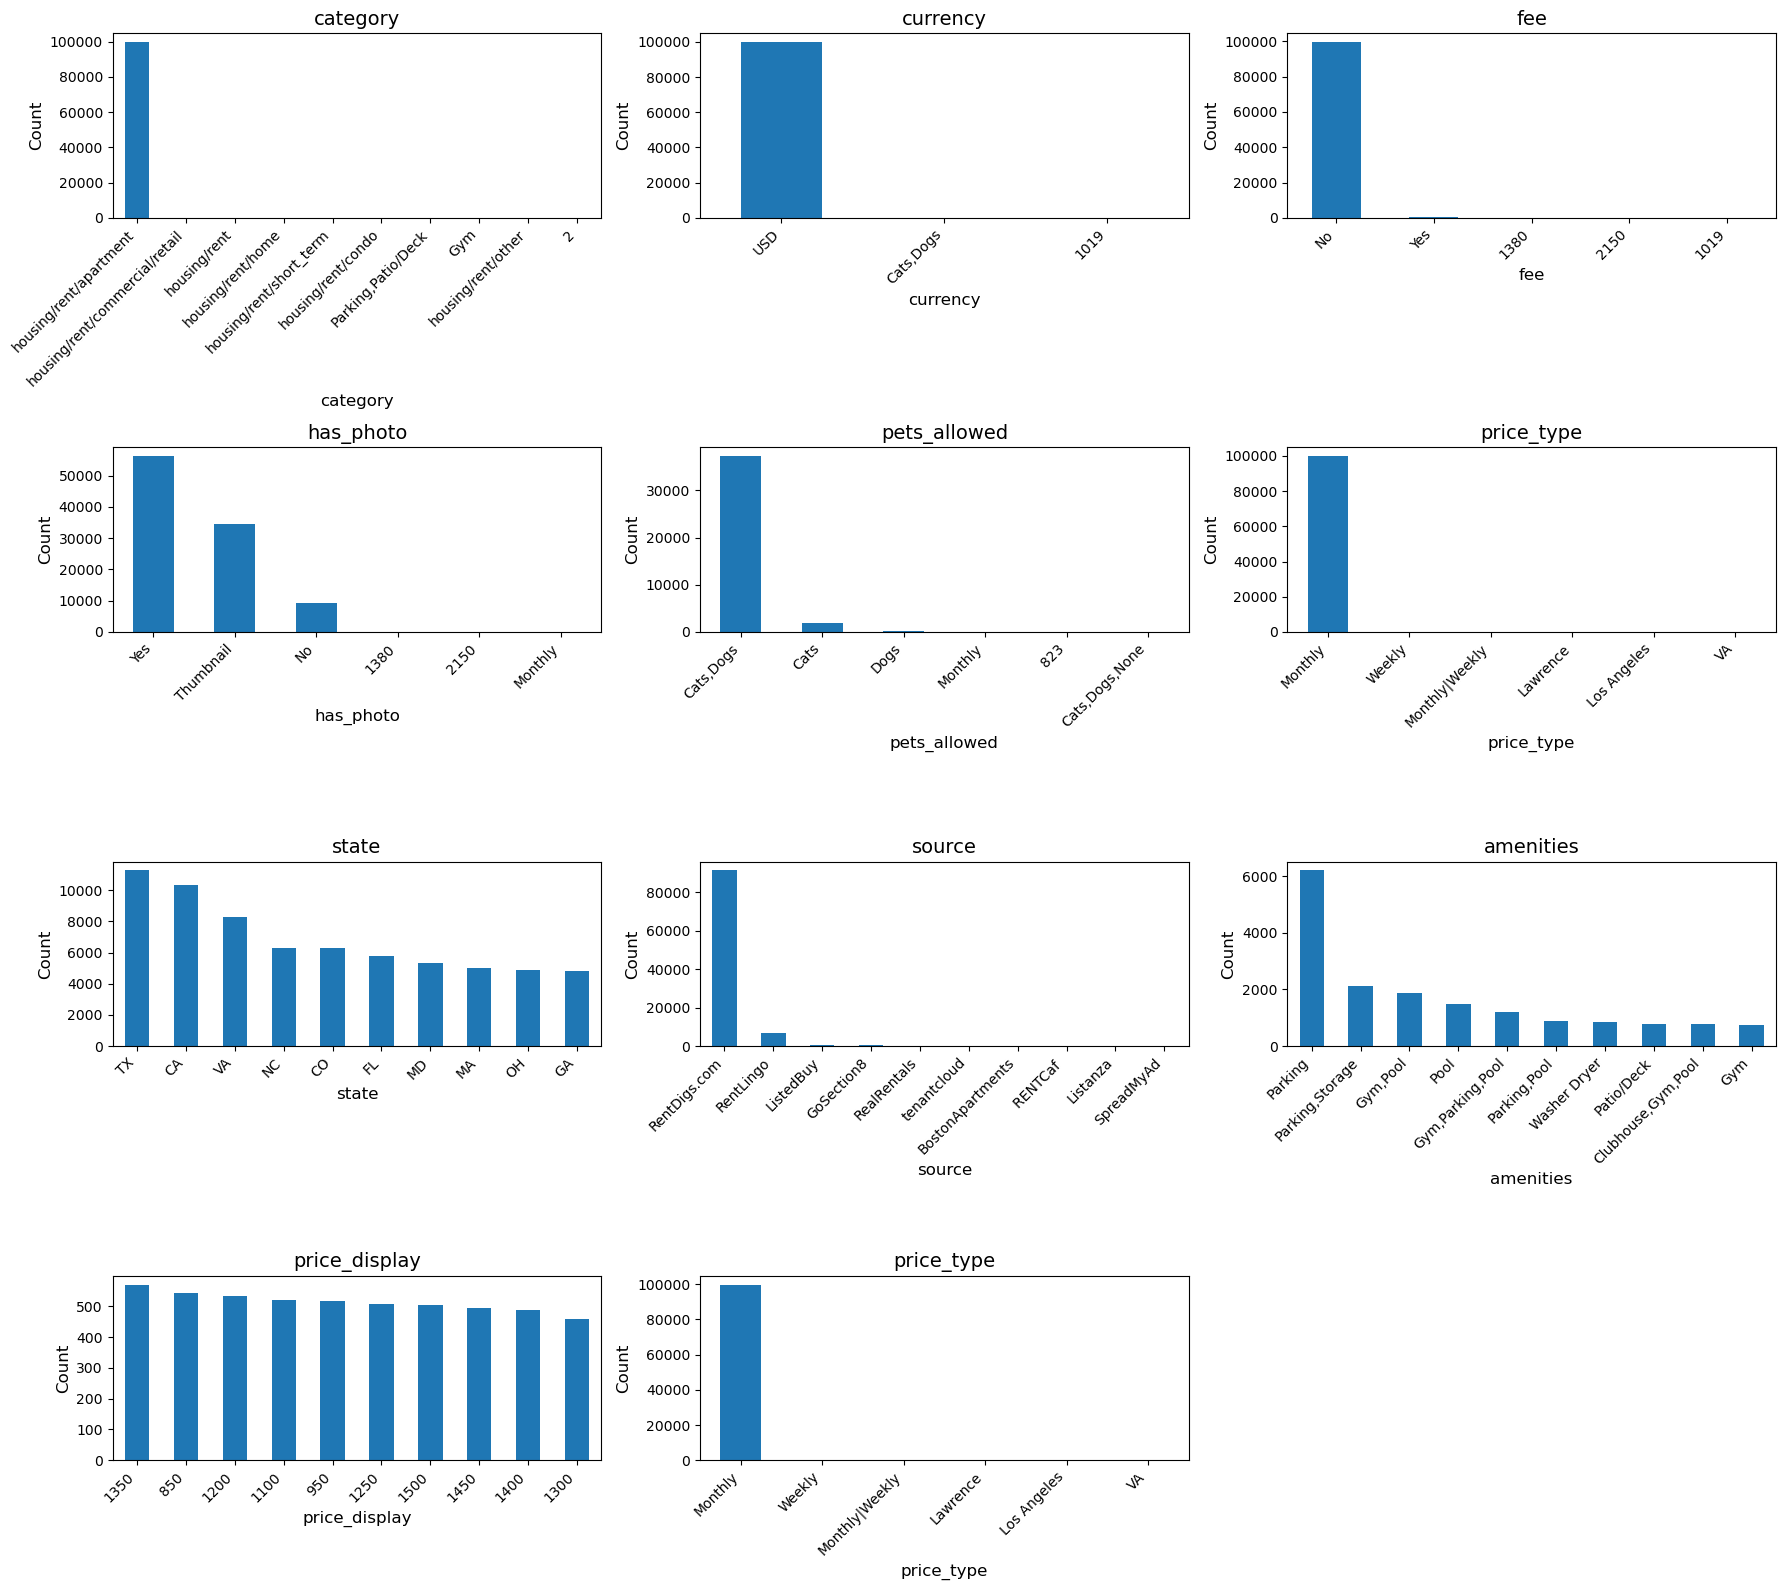

In [8]:
# Categorical column analysis with proper seaborn syntax
categorical_cols = ['category',  'currency', 'fee', 'has_photo', 
                    'pets_allowed', 'price_type', 'state', 'source','amenities','price_display','price_type']

# Filter to only include columns that exist in the dataset
categorical_cols = [col for col in categorical_cols if col in df.columns]

n_cols = 3
n_rows = (len(categorical_cols) + 1) // n_cols

plt.figure(figsize=(n_cols * 6, n_rows * 4))

for idx, col in enumerate(categorical_cols, 1):
    plt.subplot(n_rows, n_cols, idx)
    
    # Get value counts and plot
    value_counts = df[col].value_counts().head(10)  # Top 10 categories
    value_counts.plot(kind='bar')
    
    plt.title(f'{col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


## 3. Data Cleaning and Preprocessing


In [9]:
# Create a copy for preprocessing
df_clean = df.copy()

# Remove columns with high missing values (>60%)
high_missing_cols = ['pets_allowed', 'address']
df_clean = df_clean.drop(columns=[col for col in high_missing_cols if col in df_clean.columns])

# Remove text columns that are not useful for ML
text_cols = ['title', 'body', 'source']
df_clean = df_clean.drop(columns=[col for col in text_cols if col in df_clean.columns])

# Remove redundant location columns (keep latitude/longitude)
location_cols = ['cityname', 'state']
df_clean = df_clean.drop(columns=[col for col in location_cols if col in df_clean.columns])

# Remove currency column if all values are the same
if 'currency' in df_clean.columns:
    if df_clean['currency'].nunique() == 1:
        df_clean = df_clean.drop(columns=['currency'])

print(f"Shape after initial cleaning: {df_clean.shape}")
print(f"Remaining columns: {list(df_clean.columns)}")


Shape after initial cleaning: (99826, 14)
Remaining columns: ['category', 'amenities', 'bathrooms', 'bedrooms', 'currency', 'fee', 'has_photo', 'price', 'price_display', 'price_type', 'square_feet', 'latitude', 'longitude', 'time']


In [10]:
# Handle missing values
print("Missing values before imputation:")
print(df_clean.isnull().sum())

# Drop rows with missing values in critical columns
critical_cols = ['bathrooms', 'bedrooms', 'price', 'latitude', 'longitude', 'time']
df_clean = df_clean.dropna(subset=critical_cols)

# Impute missing values in amenities column
if 'amenities' in df_clean.columns:
    imputer = SimpleImputer(strategy='most_frequent')
    df_clean['amenities'] = imputer.fit_transform(df_clean[['amenities']]).flatten()

print(f"\nShape after handling missing values: {df_clean.shape}")
print("\nMissing values after imputation:")
print(df_clean.isnull().sum())


Missing values before imputation:
category             0
amenities        16077
bathrooms           69
bedrooms           130
currency             4
fee                  3
has_photo            3
price                5
price_display        6
price_type           3
square_feet          5
latitude            29
longitude           31
time                 6
dtype: int64

Shape after handling missing values: (99608, 14)

Missing values after imputation:
category         0
amenities        0
bathrooms        0
bedrooms         0
currency         0
fee              0
has_photo        0
price            0
price_display    0
price_type       0
square_feet      0
latitude         0
longitude        0
time             0
dtype: int64


## 4. Feature Engineering and Preprocessing Pipeline


In [11]:
# Split the data into train and test sets BEFORE any preprocessing
train_set, test_set = train_test_split(df_clean, test_size=0.2, random_state=42)

print(f"Training set size: {train_set.shape}")
print(f"Test set size: {test_set.shape}")

# Work with training set for preprocessing
df_train = train_set.copy()


Training set size: (79686, 14)
Test set size: (19922, 14)



Distribution of Numerical Columns in Training Set After Standardization:


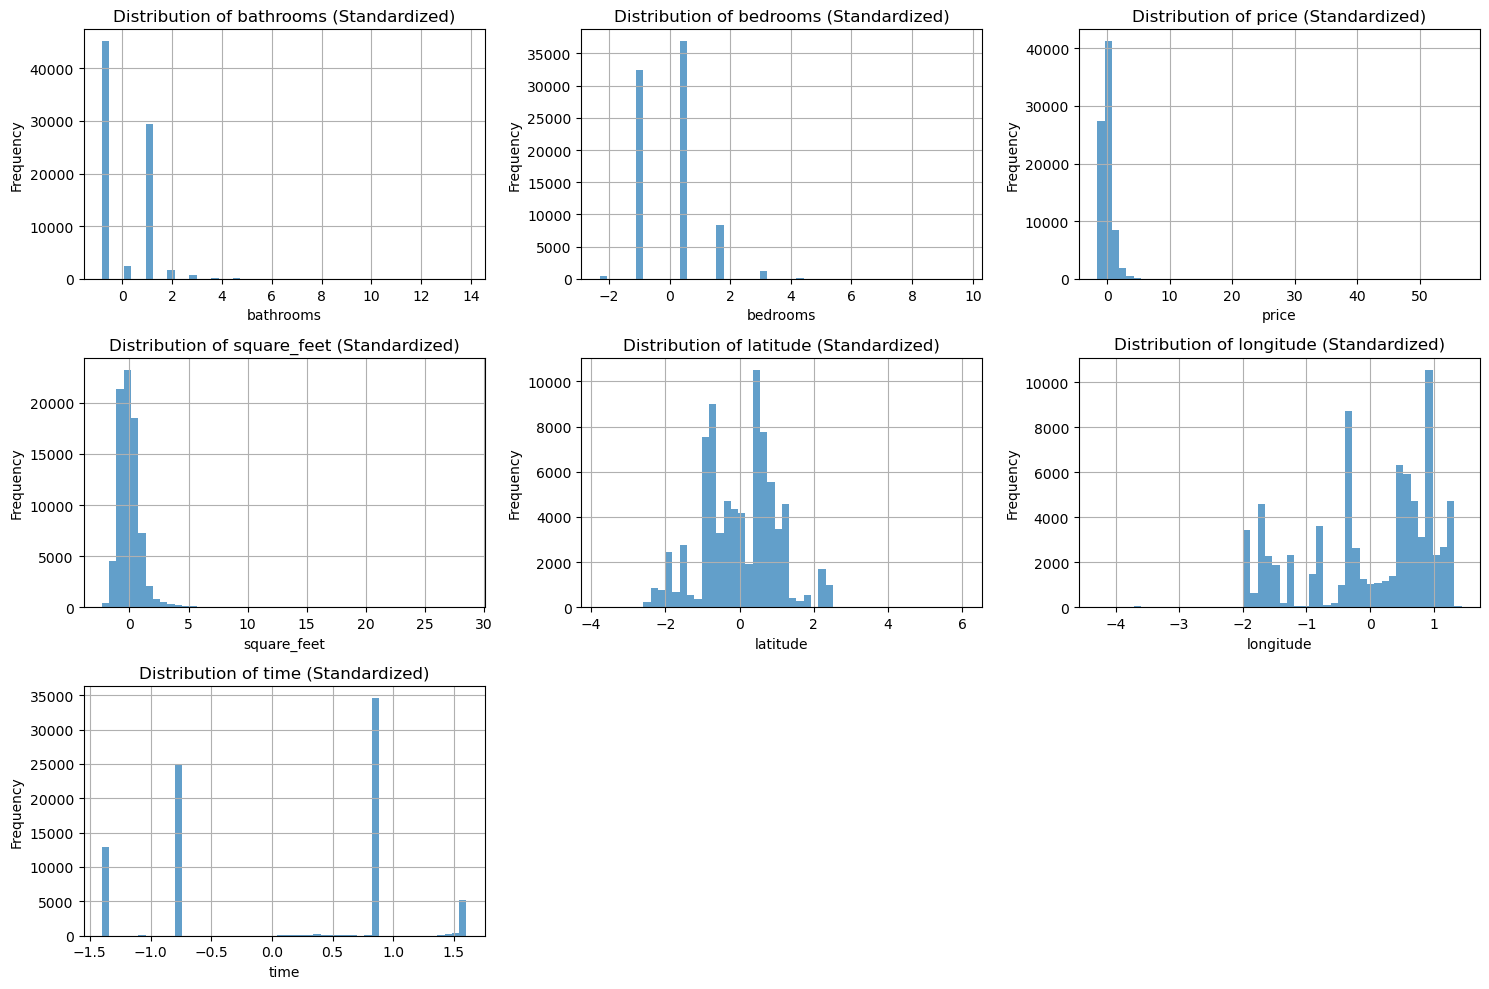

In [12]:
numerical_cols = df_train.select_dtypes(include=[np.number]).columns
df_numerical = df_train[numerical_cols].dropna()

# 2. Apply the StandardScaler
scaler = StandardScaler()
scaled_numerical_data = scaler.fit_transform(df_numerical)

# 3. Convert the scaled data back to a DataFrame to plot it
df_scaled = pd.DataFrame(scaled_numerical_data, columns=numerical_cols)

# 4. Plot the distributions of the scaled data
print("\nDistribution of Numerical Columns in Training Set After Standardization:")
plt.figure(figsize=(15, 10))

n_cols_plot = min(3, len(numerical_cols))
n_rows_plot = (len(numerical_cols) + n_cols_plot - 1) // n_cols_plot

for i, col in enumerate(df_scaled.columns, 1):
    plt.subplot(n_rows_plot, n_cols_plot, i)
    df_scaled[col].hist(bins=50, alpha=0.7)
    plt.title(f'Distribution of {col} (Standardized)')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [13]:
# Clean categorical data to prevent encoding errors
print("Cleaning categorical data...")

# Convert all categorical columns to string type to avoid mixed types
categorical_columns = df_train.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if col != 'price':  # Don't convert target variable
        print(f"Converting {col} to string type...")
        df_train[col] = df_train[col].astype(str)
        # Replace 'nan' strings with actual NaN
        df_train[col] = df_train[col].replace('nan', np.nan)

# Do the same for test set
for col in categorical_columns:
    if col != 'price':
        test_set[col] = test_set[col].astype(str)
        test_set[col] = test_set[col].replace('nan', np.nan)

print("Categorical data cleaned!")

# Identify numerical and categorical columns
numerical_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_train.select_dtypes(include=['object']).columns.tolist()

# Remove target variable from feature lists
if 'price' in numerical_cols:
    numerical_cols.remove('price')

print(f"Numerical columns: {numerical_cols}")
print(f"Categorical columns: {categorical_cols}")

# Check for any remaining mixed types in categorical columns
print("\nChecking categorical columns for mixed types:")
for col in categorical_cols:
    if col != 'price':
        unique_types = set(type(x).__name__ for x in df_train[col].dropna().unique())
        print(f"  {col}: {unique_types}")

# Create preprocessing pipeline
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine pipelines
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

print("Preprocessing pipeline created successfully!")


Cleaning categorical data...
Converting category to string type...
Converting amenities to string type...
Converting currency to string type...
Converting fee to string type...
Converting has_photo to string type...
Converting price_display to string type...
Converting price_type to string type...
Categorical data cleaned!
Numerical columns: ['bathrooms', 'bedrooms', 'square_feet', 'latitude', 'longitude', 'time']
Categorical columns: ['category', 'amenities', 'currency', 'fee', 'has_photo', 'price_display', 'price_type']

Checking categorical columns for mixed types:
  category: {'str'}
  amenities: {'str'}
  currency: {'str'}
  fee: {'str'}
  has_photo: {'str'}
  price_display: {'str'}
  price_type: {'str'}
Preprocessing pipeline created successfully!


## 5. Model Training and Evaluation


In [15]:
# Prepare features and target
X_train = df_train.drop('price', axis=1)
y_train = df_train['price']

X_test = test_set.drop('price', axis=1)
y_test = test_set['price']

print(f"Training features shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Test target shape: {y_test.shape}")

# Final data type check before preprocessing
print("\nFinal data types before preprocessing:")
print(X_train.dtypes)

# Additional safety: ensure all categorical columns are strings
for col in X_train.select_dtypes(include=['object']).columns:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)
    # Replace 'nan' strings with actual NaN
    X_train[col] = X_train[col].replace('nan', np.nan)
    X_test[col] = X_test[col].replace('nan', np.nan)

print("\nAttempting to fit preprocessor...")
try:
    # Fit the preprocessor on training data
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    print(f"Preprocessing successful!")
    print(f"Processed training features shape: {X_train_processed.shape}")
    print(f"Processed test features shape: {X_test_processed.shape}")
    
except Exception as e:
    print(f"Preprocessing failed with error: {e}")
    print("Attempting to debug the issue...")
    
    # Debug: check each categorical column individually
    for col in X_train.select_dtypes(include=['object']).columns:
        print(f"\nDebugging column: {col}")
        print(f"  Unique values (first 10): {X_train[col].unique()[:10]}")
        print(f"  Data types: {set(type(x).__name__ for x in X_train[col].dropna().unique())}")
        
        # Try to identify problematic values
        try:
            test_series = X_train[col].dropna()
            test_series.value_counts().head()
            print(f"Column {col} looks OK")
        except Exception as col_error:
            print(f"Column {col} has issues: {col_error}")
    
    raise e


Training features shape: (79686, 13)
Training target shape: (79686,)
Test features shape: (19922, 13)
Test target shape: (19922,)

Final data types before preprocessing:
category          object
amenities         object
bathrooms        float64
bedrooms         float64
currency          object
fee               object
has_photo         object
price_display     object
price_type        object
square_feet      float64
latitude         float64
longitude        float64
time             float64
dtype: object

Attempting to fit preprocessor...
Preprocessing successful!
Processed training features shape: (79686, 12478)
Processed test features shape: (19922, 12478)


In [16]:
print("="*50)
print("Calculating Benchmark Model Performance...")
print("="*50)

# 1. Calculate the average rental price from the training data
average_price_train = y_train.mean()
print(f"Average rental price in training set: ${average_price_train:.2f}")

# 2. Create a list of predictions for the test set, where every prediction is the average price
benchmark_predictions = np.full(shape=y_test.shape, fill_value=average_price_train)

# 3. Calculate the metrics for the benchmark model
benchmark_mae = mean_absolute_error(y_test, benchmark_predictions)
benchmark_mse = mean_squared_error(y_test, benchmark_predictions)
benchmark_rmse = np.sqrt(benchmark_mse)
benchmark_r2 = r2_score(y_test, benchmark_predictions)

# 4. Print the results
print(f"\nBenchmark Performance on Test Set:")
print(f"Test MAE: ${benchmark_mae:.2f}")
print(f"Test RMSE: ${benchmark_rmse:.2f}")
print(f"Test R²: {benchmark_r2:.4f}")


Calculating Benchmark Model Performance...
Average rental price in training set: $1526.22

Benchmark Performance on Test Set:
Test MAE: $545.58
Test RMSE: $901.89
Test R²: -0.0000


In [17]:
import time
# Optional: Use a smaller subset for faster testing 
SAMPLE_SIZE_TRAIN = 2000  # set None to use all data
SAMPLE_SIZE_TEST = 500

if SAMPLE_SIZE_TRAIN is not None and X_train_processed.shape[0] > SAMPLE_SIZE_TRAIN:
    X_train_processed = X_train_processed[:SAMPLE_SIZE_TRAIN]
    y_train = y_train[:SAMPLE_SIZE_TRAIN]

if SAMPLE_SIZE_TEST is not None and X_test_processed.shape[0] > SAMPLE_SIZE_TEST:
    X_test_processed = X_test_processed[:SAMPLE_SIZE_TEST]
    y_test = y_test[:SAMPLE_SIZE_TEST]

# Define models
models = {
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5, algorithm='ball_tree'),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=50, random_state=42)  # reduced n_estimators for speed
}

results = {}

# Train and evaluate
for name, model in models.items():
    print(f"\n Training {name}...")
    start_time = time.time()
    
    # Train
    model.fit(X_train_processed, y_train)
    fit_time = time.time() - start_time
    print(f"  Fit completed in {fit_time:.2f} sec")

    # Predict
    start_pred = time.time()
    y_train_pred = model.predict(X_train_processed)
    y_test_pred = model.predict(X_test_processed)
    pred_time = time.time() - start_pred
    print(f"   Prediction completed in {pred_time:.2f} sec")

    # Metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    results[name] = {
        'Train RMSE': np.sqrt(train_mse),
        'Test RMSE': np.sqrt(test_mse),
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Fit Time (s)': fit_time,
        'Predict Time (s)': pred_time
    }

    # Print individual results
    print(f" {name} Results:")
    print(f"   Train RMSE: {np.sqrt(train_mse):.2f}")
    print(f"   Test RMSE:  {np.sqrt(test_mse):.2f}")
    print(f"   Train MAE:  {train_mae:.2f}")
    print(f"   Test MAE:   {test_mae:.2f}")
    print(f"   Train R²:   {train_r2:.4f}")
    print(f"   Test R²:    {test_r2:.4f}")

#  Summary table
results_df = pd.DataFrame(results).T
print("\n Final Model Comparison:")
print(results_df.sort_values(by="Test RMSE"))

#  Optional: display nicely in Jupyter
try:
    import IPython.display as display
    display.display(results_df.style.format("{:.4f}"))
except:
    pass



 Training K-Nearest Neighbors...
  Fit completed in 1.70 sec
   Prediction completed in 75.18 sec
 K-Nearest Neighbors Results:
   Train RMSE: 574.35
   Test RMSE:  622.72
   Train MAE:  331.20
   Test MAE:   395.42
   Train R²:   0.6471
   Test R²:    0.2784

 Training Decision Tree...
  Fit completed in 0.74 sec
   Prediction completed in 0.07 sec
 Decision Tree Results:
   Train RMSE: 0.00
   Test RMSE:  802.28
   Train MAE:  0.00
   Test MAE:   368.15
   Train R²:   1.0000
   Test R²:    -0.1977

 Training Random Forest...
  Fit completed in 18.28 sec
   Prediction completed in 0.13 sec
 Random Forest Results:
   Train RMSE: 223.41
   Test RMSE:  455.20
   Train MAE:  113.46
   Test MAE:   272.51
   Train R²:   0.9466
   Test R²:    0.6144

 Final Model Comparison:
                     Train RMSE   Test RMSE  Train MAE   Test MAE  Train R²  \
Random Forest        223.408867  455.198903  113.45694  272.51156  0.946602   
K-Nearest Neighbors  574.345850  622.724868  331.19600  395.4

,Train RMSE,Test RMSE,Train MAE,Test MAE,Train R²,Test R²,Fit Time (s),Predict Time (s)
K-Nearest Neighbors,574.3459,622.7249,331.1960,395.4176,0.6471,0.2784,1.6973,75.1828
Decision Tree,0.0000,802.2816,0.0000,368.1480,1.0000,-0.1977,0.7359,0.0730
Random Forest,223.4089,455.1989,113.4569,272.5116,0.9466,0.6144,18.2839,0.1297


In [18]:
# Train multiple models and compare performance
models = {
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model
    model.fit(X_train_processed, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train_processed)
    y_test_pred = model.predict(X_test_processed)
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    results[name] = {
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': np.sqrt(train_mse),
        'test_rmse': np.sqrt(test_mse),
        'train_mae': train_mae,
        'test_mae': test_mae
    }
    
    print(f"{name} Results:")
    print(f"  Train RMSE: {np.sqrt(train_mse):.2f}")
    print(f"  Test RMSE: {np.sqrt(test_mse):.2f}")
    print(f"  Train MAE: {train_mae:.2f}")
    print(f"  Test MAE: {test_mae:.2f}")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²: {test_r2:.4f}")



Training K-Nearest Neighbors...
K-Nearest Neighbors Results:
  Train RMSE: 574.35
  Test RMSE: 622.72
  Train MAE: 331.20
  Test MAE: 395.42
  Train R²: 0.6471
  Test R²: 0.2784

Training Decision Tree...
Decision Tree Results:
  Train RMSE: 0.00
  Test RMSE: 802.28
  Train MAE: 0.00
  Test MAE: 368.15
  Train R²: 1.0000
  Test R²: -0.1977

Training Random Forest...
Random Forest Results:
  Train RMSE: 225.89
  Test RMSE: 452.68
  Train MAE: 112.13
  Test MAE: 272.56
  Train R²: 0.9454
  Test R²: 0.6187


In [19]:
#  Create a clean comparison table
results_df = pd.DataFrame(results).T
print("\n Model Comparison:")
print("=" * 90)
print(results_df[['Train RMSE', 'Test RMSE', 'Train MAE', 'Test MAE', 'Train R²', 'Test R²']].round(4))

#  Identify the best models for each metric
best_r2_model = results_df['Test R²'].idxmax()
best_rmse_model = results_df['Test RMSE'].idxmin()
best_mae_model = results_df['Test MAE'].idxmin()

print("\n🏆 Best Models by Metric:")
print(f"  • Best model based on Test R²   : {best_r2_model} (R² = {results_df.loc[best_r2_model, 'Test R²']:.4f})")
print(f"  • Best model based on Test RMSE : {best_rmse_model} (RMSE = {results_df.loc[best_rmse_model, 'Test RMSE']:.2f})")
print(f"  • Best model based on Test MAE  : {best_mae_model} (MAE = {results_df.loc[best_mae_model, 'Test MAE']:.2f})")



 Model Comparison:


KeyError: "None of [Index(['Train RMSE', 'Test RMSE', 'Train MAE', 'Test MAE', 'Train R²',\n       'Test R²'],\n      dtype='object')] are in the [columns]"


Decision Tree Feature Importance Analysis:

Top 10 Most Important Features for Decision Tree:
                   feature  importance
0                bathrooms    0.247874
4                longitude    0.223206
2              square_feet    0.165290
5                     time    0.095515
3                 latitude    0.085270
9219   price_display_12600    0.027795
9052   price_display_11000    0.020039
10933   price_display_3000    0.010017
11997   price_display_5900    0.009791
9921   price_display_19500    0.008091


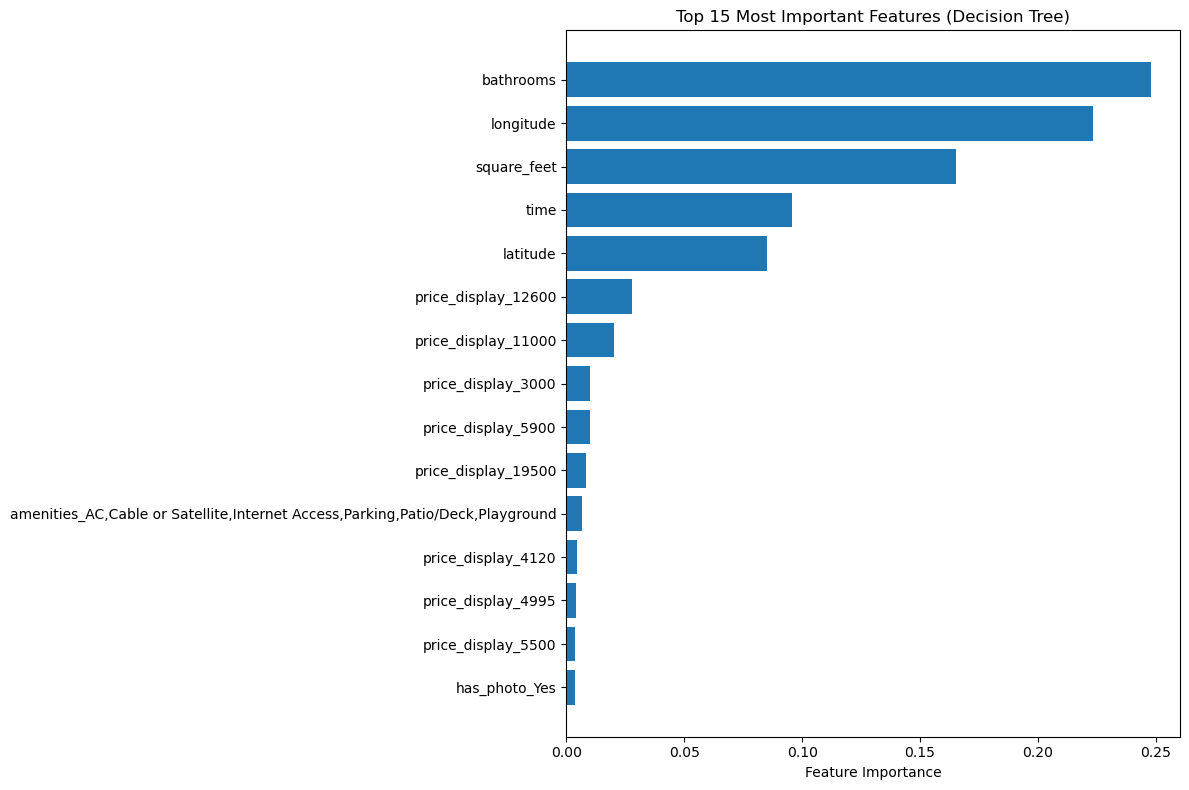


Random Forest Feature Importance Analysis:

Top 10 Most Important Features for Random Forest:
                                feature  importance
4                             longitude    0.247038
2                           square_feet    0.194301
0                             bathrooms    0.161455
3                              latitude    0.084498
9921                price_display_19500    0.056667
5                                  time    0.041182
9219                price_display_12600    0.030376
8803  amenities_Patio/Deck,Refrigerator    0.015144
9052                price_display_11000    0.009748
1                              bedrooms    0.007591


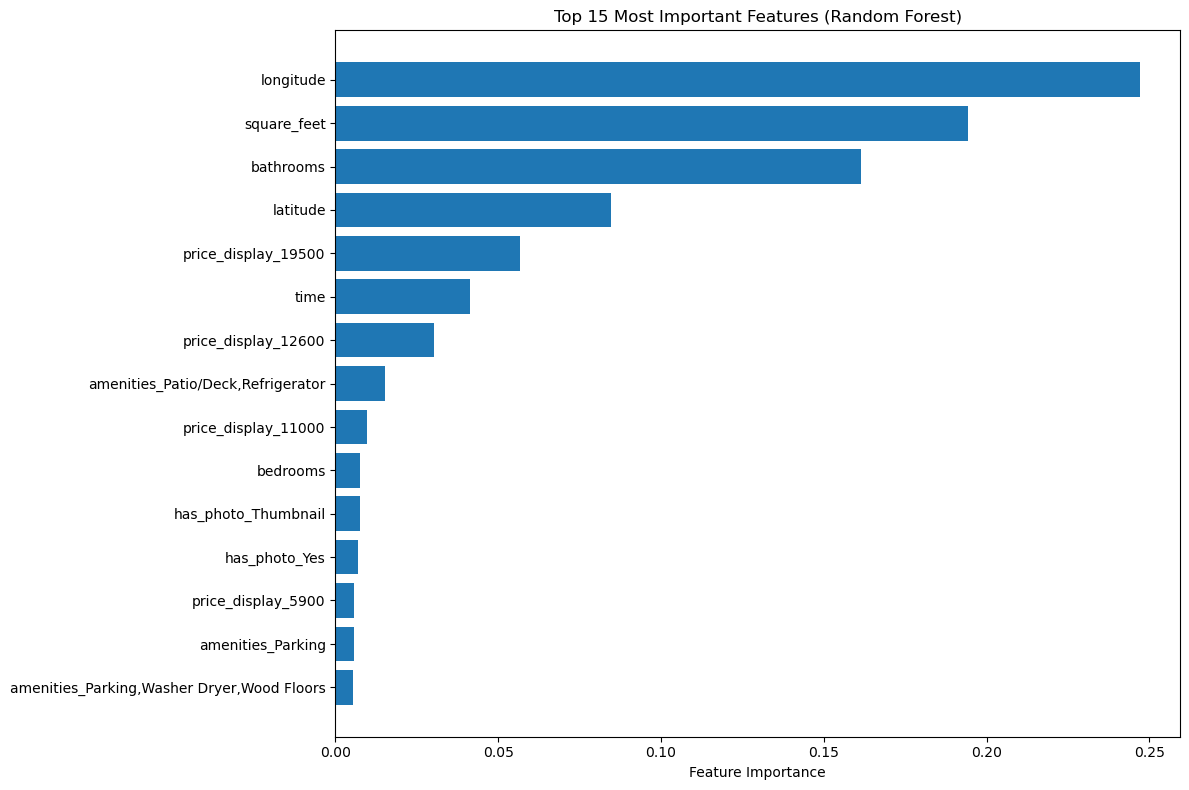


K-Nearest Neighbors Analysis:
Number of neighbors used: 5
Note: KNN doesn't provide feature importance, but it's useful for:
- Non-parametric learning
- Handling non-linear relationships
- Good baseline model


In [17]:
# Feature importance analysis for tree-based models
tree_models = ['Decision Tree', 'Random Forest']

for model_name in tree_models:
    if model_name in models:
        print(f"\n{model_name} Feature Importance Analysis:")
        print("=" * 50)
        
        model = models[model_name]
        feature_importance = model.feature_importances_
        
        # Get feature names from the preprocessor
        feature_names = []
        for name, transformer, columns in preprocessor.transformers_:
            if name == 'num':
                feature_names.extend(columns)
            elif name == 'cat':
                # For one-hot encoded features, we need to get the feature names
                cat_feature_names = transformer.get_feature_names_out(columns)
                feature_names.extend(cat_feature_names)
        
        # Create feature importance DataFrame
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_importance
        }).sort_values('importance', ascending=False)
        
        print(f"\nTop 10 Most Important Features for {model_name}:")
        print(importance_df.head(10))
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        top_features = importance_df.head(15)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'Top 15 Most Important Features ({model_name})')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

# KNN doesn't have feature importance, but we can analyze prediction patterns
if 'K-Nearest Neighbors' in models:
    print(f"\nK-Nearest Neighbors Analysis:")
    print("=" * 40)
    knn_model = models['K-Nearest Neighbors']
    print(f"Number of neighbors used: {knn_model.n_neighbors}")
    print("Note: KNN doesn't provide feature importance, but it's useful for:")
    print("- Non-parametric learning")
    print("- Handling non-linear relationships")
    print("- Good baseline model")


## 6. Hyperparameter Tuning 

In [18]:
# Optional: Hyperparameter tuning for better performance
print("Hyperparameter Tuning (Optional)")
print("=" * 50)

# Define parameter grids for each model
param_grids = {
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
}

# Perform grid search for each model (using a subset of data for speed)
print("Note: Grid search can be time-consuming. Using a sample for demonstration.")
sample_size = min(5000, len(X_train_processed))
X_sample = X_train_processed[:sample_size]
y_sample = y_train[:sample_size]

tuned_models = {}

for model_name, param_grid in param_grids.items():
    print(f"\nTuning {model_name}...")
    
    # Get the base model
    if model_name == 'K-Nearest Neighbors':
        base_model = KNeighborsRegressor()
    elif model_name == 'Decision Tree':
        base_model = DecisionTreeRegressor(random_state=42)
    elif model_name == 'Random Forest':
        base_model = RandomForestRegressor(random_state=42)
    
    # Perform grid search
    grid_search = GridSearchCV(
        base_model, 
        param_grid, 
        cv=3,  # Reduced CV for speed
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_sample, y_sample)
    
    # Store the best model
    tuned_models[model_name] = grid_search.best_estimator_
    
    print(f"Best parameters for {model_name}:")
    for param, value in grid_search.best_params_.items():
        print(f"  {param}: {value}")
    print(f"Best CV score: {-grid_search.best_score_:.4f}")

print(f"\nHyperparameter tuning completed!")
print("You can use tuned_models dictionary to access the optimized models.")


Hyperparameter Tuning (Optional)
Note: Grid search can be time-consuming. Using a sample for demonstration.

Tuning K-Nearest Neighbors...
Best parameters for K-Nearest Neighbors:
  metric: euclidean
  n_neighbors: 3
  weights: distance
Best CV score: 522605.2956

Tuning Decision Tree...
Best parameters for Decision Tree:
  max_depth: None
  min_samples_leaf: 1
  min_samples_split: 2
Best CV score: 450664.4038

Tuning Random Forest...
Best parameters for Random Forest:
  max_depth: 20
  min_samples_split: 2
  n_estimators: 50
Best CV score: 363920.7481

Hyperparameter tuning completed!
You can use tuned_models dictionary to access the optimized models.


## 6. Summary and Conclusions


In [19]:
# Final summary
print("=" * 80)
print("ANALYSIS SUMMARY")
print("=" * 80)

print(f"Original dataset size: {df.shape}")
print(f"Final cleaned dataset size: {df_clean.shape}")
print(f"Training set size: {train_set.shape}")
print(f"Test set size: {test_set.shape}")

print(f"\nData preprocessing steps completed:")
print("✓ Removed high missing value columns")
print("✓ Removed text and redundant columns") 
print("✓ Handled missing values with imputation")
print("✓ Created proper train/test split")
print("✓ Applied feature scaling and encoding")

print(f"\nModels trained and evaluated:")
for name in models.keys():
    print(f"✓ {name}")

print(f"\nModel Performance Summary:")
print("-" * 40)
for name in models.keys():
    r2_score = results_df.loc[name, 'test_r2']
    rmse_score = results_df.loc[name, 'test_rmse']
    mae_score = results_df.loc[name, 'test_mae']
    print(f"{name:20} | R²: {r2_score:.4f} | RMSE: {rmse_score:.2f} | MAE: {mae_score:.2f}")

print(f"\nBest performing models:")
print(f"• Best R² Score: {best_r2_model} ({results_df.loc[best_r2_model, 'test_r2']:.4f})")
print(f"• Best RMSE: {best_rmse_model} ({results_df.loc[best_rmse_model, 'test_rmse']:.2f})")
print(f"• Best MAE: {best_mae_model} ({results_df.loc[best_mae_model, 'test_mae']:.2f})")

print(f"\nAnalysis completed successfully! 🎉")


ANALYSIS SUMMARY
Original dataset size: (99826, 21)
Final cleaned dataset size: (99608, 14)
Training set size: (79686, 14)
Test set size: (19922, 14)

Data preprocessing steps completed:
✓ Removed high missing value columns
✓ Removed text and redundant columns
✓ Handled missing values with imputation
✓ Created proper train/test split
✓ Applied feature scaling and encoding

Models trained and evaluated:
✓ K-Nearest Neighbors
✓ Decision Tree
✓ Random Forest

Model Performance Summary:
----------------------------------------


KeyError: 'test_r2'